In [10]:
pwd

'/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/notebooks/census'

time: 13.8 ms


In [1]:
%load_ext autotime

In [3]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

time: 145 ms


In [4]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',
}

time: 956 µs


In [13]:
full_individual_df = pd.read_stata(
    get_data_dir('/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/data/raw/census_private/census_dummy_0.001_pct.dta'))

time: 175 ms


In [14]:
full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

time: 10.6 ms


In [15]:
full_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
0,3645901,6,21,1,32,female,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
1,2837395,3,21,1,3,female,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
2,3643108,4,21,1,27,female,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
3,127433,6,21,1,9,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
4,142476,8,21,1,19,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo


time: 81.9 ms


In [17]:
l = '''Not working, inactive, not in universe
In School
Homemakers/Housework
Office workers
Service Workers
Agriculture Workers
Disabled and not working'''
l = l.split('\n')
full_individual_df['economic_status'].value_counts()[l]

# removing Industry workers and In the Army because dummy dataset doesn't contain these categories 

Not working, inactive, not in universe    41
In School                                 36
Homemakers/Housework                      17
Office workers                             2
Service Workers                           21
Agriculture Workers                       23
Disabled and not working                   1
Name: economic_status, dtype: int64

time: 17.3 ms


# Fill unknown age

In [18]:
individual_df = full_individual_df

time: 568 µs


In [19]:
# missing_val = 'not reported/missing'
age_cols = ['geo1_zw2012', 'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

time: 48.8 ms


In [20]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

time: 85.4 ms


<AxesSubplot:>

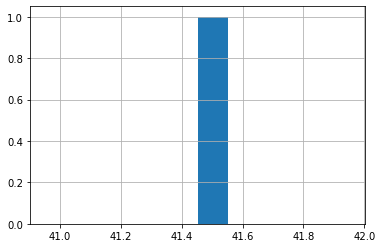

time: 343 ms


In [22]:
pd.Series(gb.predict(missing_age)).hist()

In [23]:
X_tr.shape

(7, 25)

time: 3 ms


In [24]:
individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
71,988027,8,3007,22,41,female,0,1 family,subsistence agricultural and fishery workers,1,...,0.108041,mashonaland east,mashonaland east,3,mutoko,mutoko,mashonaland east,5,Mashonaland East,Mutoko


time: 85.5 ms


In [25]:
individual_df.economic_status.astype(str).value_counts()

Not working, inactive, not in universe    41
In School                                 36
Agriculture Workers                       23
Service Workers                           21
Homemakers/Housework                      17
Office workers                             2
Disabled and not working                   1
Name: economic_status, dtype: int64

time: 9.14 ms


## Create `ward_id`, `household_id` and `economic_activity_location_id`

In [26]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'household', 'ward'
]

time: 936 µs


In [33]:
old_new_districts = pd.read_csv('/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/data/raw/district_relation.csv', index_col=0)
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()
old_new_districts.head()

,CNTRY_NAME,ADMIN_NAME,CNTRY_CODE,IPUM2012,DIST2012,PARENT,NEW_DIST_ID_2
ADMIN_NAME,,,,,,,
bulawayo urban,Zimbabwe,Bulawayo Urban,716,21,21,0,1
buhera,Zimbabwe,Buhera,716,1001,101,1,3
chimanimani,Zimbabwe,Chimanimani,716,1002,102,1,4
chipinge rural,Zimbabwe,Chipinge Rural,716,1003,103,1,5
makoni,Zimbabwe,Makoni,716,1004,104,1,6


time: 24.1 ms


In [31]:
individual_df['serial_expanded'] = individual_df['serial']

time: 5.34 ms


In [34]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['old_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["DIST2012"][x]}')                                          
individual_df['new_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["NEW_DIST_ID_2"][x]}')

time: 13.2 ms


In [35]:
expanded_individual_df = individual_df.copy()

time: 6.58 ms


In [36]:
expanded_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile,serial_expanded,household_id,old_ward_id,new_ward_id
0,3645901,6,21,1,32,female,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,3645901,h_3645901,w_21,w_1
1,2837395,3,21,1,3,female,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,2837395,h_2837395,w_21,w_1
2,3643108,4,21,1,27,female,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,3643108,h_3643108,w_21,w_1
3,127433,6,21,1,9,male,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,127433,h_127433,w_21,w_1
4,142476,8,21,1,19,male,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,142476,h_142476,w_21,w_1


time: 58.6 ms


In [37]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 11.3 ms


In [38]:
expanded_individual_df.columns

Index(['serial', 'persons', 'district_id', 'new_district_id', 'age', 'sex',
       'teachers', 'nfams', 'isco88a', 'famunit', 'urban', 'economic_status',
       'gq', 'marst', 'citizen', 'race', 'disabled', 'disblnd', 'disdeaf',
       'dismntl', 'famsize', 'age2', 'edattain', 'edattaind', 'yrschool',
       'educzw', 'empstat', 'empstatd', 'labforce', 'occisco', 'occ',
       'manufacturing_workers', 'mining_workers', 'mining_districts', 'pid',
       'weight', 'ward', 'school_goers', 'school_goers_detailed', 'pernum',
       'geolev1', 'Province', 'Province_str', 'ProvincePop2012',
       'ProvincePop2019', 'geolev2', 'new_district_id_st', 'NewDistPop2012',
       'NewDistPop2019', 'new_dist_pop_share', 'geo1_zw', 'geo1_zw2012',
       'geo1_string', 'geo2_zw', 'geo2_zw2012', 'dhs_ipumsi_zw',
       'province_id_shpfile', 'province_name_shpfile', 'district_name_shpfile',
       'serial_expanded', 'household_id', 'old_ward_id', 'new_ward_id'],
      dtype='object')

time: 5.82 ms


In [39]:
expanded_individual_df.groupby('serial')['sex'].count().mean()

1.0

time: 10.2 ms


In [40]:
expanded_individual_df.shape[0] / expanded_individual_df['serial'].nunique()

1.0

time: 4.26 ms


In [41]:
(expanded_individual_df['school_goers'] == 1).sum()

36

time: 4.17 ms


In [42]:
(expanded_individual_df['school_goers'] == 1).sum()

36

time: 5.1 ms


# Mining

In [43]:
# relevant_cols = [
#     'person_id', 'age', 'sex',
#     'household_id', 'ward_id',
#     'economic_status', 'economic_activity_location_id',
#     'school_id_district', 
#     'manufacturing_workers',
#     'mining_district_id'
#     # 'household', 'ward'
# ]

relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    # 'mining_district_id'
    # 'household', 'ward'
]

time: 704 µs


In [45]:
mining_df = expanded_individual_df.copy()

p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

mining_df[relevant_cols].to_pickle(
    get_data_dir('/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/data/preprocessed/census/zimbabwe_ipums_dummy.pickle'))

time: 47.7 ms


In [46]:
mining_df[relevant_cols].head()

,person_id,age,sex,household_id,ward_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers
0,0,32,female,h_3645901,w_1,Homemakers/Housework,w_1,0,0.0
1,1,3,female,h_2837395,w_1,"Not working, inactive, not in universe",w_1,0,0.0
2,2,27,female,h_3643108,w_1,"Not working, inactive, not in universe",w_1,0,0.0
3,3,9,male,h_127433,w_1,"Not working, inactive, not in universe",w_1,0,0.0
4,4,19,male,h_142476,w_1,In School,w_1,1,0.0


time: 20.1 ms


# Contingent on available data

In [47]:
# mining_df['serial_expanded'] = mining_df['serial'].map(lambda x: f'{x}_01')
# mining_df['household_id'] = mining_df['serial_expanded'].map(lambda x: f'h_{x}')
mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'] = mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'] = mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

KeyError: 'mining_district_id'

time: 109 ms


In [ ]:
mining_df.head()

In [ ]:
p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

In [ ]:
try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01') | mining_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df.shape

In [ ]:
import pandas as pd

In [ ]:
mining_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id']

# Expand to 10%

In [ ]:
mining_df

# Scratch

In [ ]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

In [ ]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

In [ ]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

In [ ]:
mining_df['school_id_district'].shape